In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [18]:
import os

os.getcwd()

'C:\\Users\\anniw\\IFT6758-A2022-G08'

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import src.visualization.visualize as VizManager
import src.features.build_features as FeaturesManager

In [20]:
SEED = 42

In [21]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data = FeaturesManager.build_features(seasons_year, season_type)

In [22]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305860 entries, 0 to 305859
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Game ID                         305860 non-null  object 
 1   Event Index                     305860 non-null  int64  
 2   Period                          305860 non-null  int64  
 3   Team                            305860 non-null  object 
 4   Type                            305860 non-null  object 
 5   Shot Type                       305827 non-null  object 
 6   Shooter                         305860 non-null  object 
 7   Shooter ID                      305860 non-null  float64
 8   Goalie                          305860 non-null  object 
 9   Goalie ID                       305860 non-null  float64
 10  Strength                        305860 non-null  object 
 11  X                               305860 non-null  float64
 12  Y               

In [23]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline # Outlier not integrated in pipeline actually

In [24]:
# Separate features from target
X = features_data.drop(['Is Goal', 'Type'], axis=1)
y = features_data['Is Goal']

In [25]:
# Data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [26]:
X_train.shape, X_valid.shape

((244688, 35), (61172, 35))

In [27]:
import warnings 
warnings.filterwarnings("ignore")

In [28]:
# Check how many shots are in defensive zone - these are potentially outliers if not empty net
out = X_train[X_train['st_X'] < -25]['st_X'].count()
X_train.shape[0] - out # we should expect approximately this much rows left after outlier removal

235126

<AxesSubplot:xlabel='st_X'>

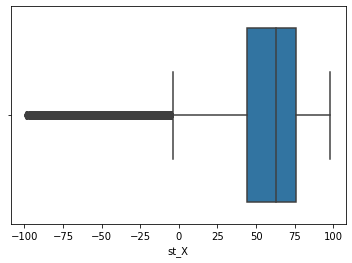

In [29]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Outliers - Boxplot
sns.boxplot(x=X_train['st_X']) # hahaha

<AxesSubplot:xlabel='st_X', ylabel='Count'>

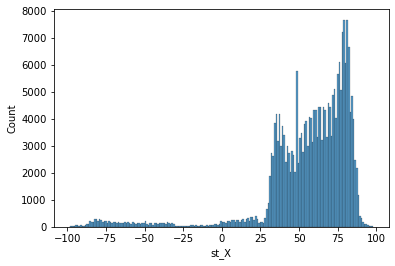

In [30]:
# Distribution before outliers removal
sns.histplot(X_train['st_X'])

In [31]:
# Outliers - Percentile
min_thresold, max_thresold = X_train['st_X'].quantile([0.05, 0.95]) # define threshold

percentile_mask = ~(X_train['st_X']<min_thresold) | (X_train['st_X']>max_thresold) # create bool mask for threshold

X_train_percentile = X_train[percentile_mask]
y_train_percentile  = y_train[percentile_mask]

X_train_percentile.shape, y_train_percentile.shape

((232518, 35), (232518,))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

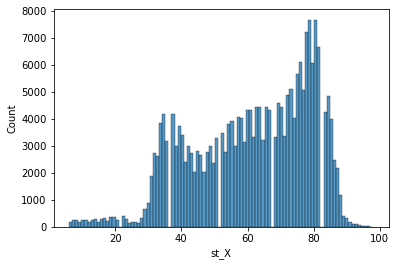

In [32]:
sns.histplot(X_train_percentile['st_X'])

In [33]:
# Outliers - IQR
Q1 = X_train['st_X'].quantile(0.25)
Q3 = X_train['st_X'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

IQR_mask = ~(X_train['st_X']<lower_limit) | (X_train['st_X']>upper_limit)
X_train_IQR = X_train[IQR_mask]
y_train_IQR = y_train[IQR_mask]

X_train_IQR.shape, X_train_IQR.shape 

((234011, 35), (234011, 35))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

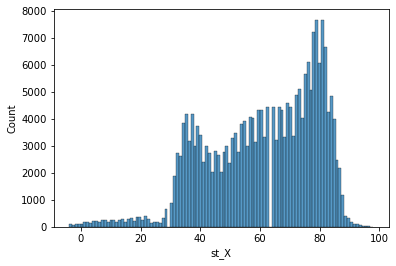

In [34]:
sns.histplot(X_train_IQR['st_X'])

In [35]:
# Outliers - STD
factor = 2
upper_limit = X_train['st_X'].mean() + factor*X_train['st_X'].std()
lower_limit = X_train['st_X'].mean() - factor*X_train['st_X'].std()

std_mask = (X_train['st_X']<upper_limit) & (X_train['st_X']>lower_limit)

X_train_std = X_train[std_mask]
y_train_std = y_train[std_mask]

X_train_std.shape, X_train_std.shape 

((234119, 35), (234119, 35))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

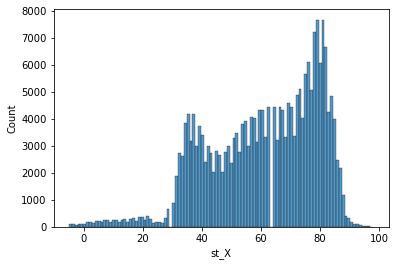

In [36]:
sns.histplot(X_train_std['st_X'])

In [37]:
# Outliers - Z-Score
threshold = 3
zscore_mask = ~(np.abs(stats.zscore(X_train['st_X'])) > threshold)

X_train_zscore = X_train[zscore_mask]
y_train_zscore = y_train[zscore_mask]

X_train_zscore.shape, y_train_zscore.shape

((235962, 35), (235962,))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

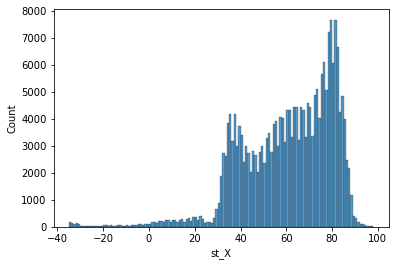

In [38]:
sns.histplot(X_train_zscore['st_X'])

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test = pd.DataFrame(scaler.fit_transform(X_train[['st_X']]))

<AxesSubplot:xlabel='0', ylabel='Count'>

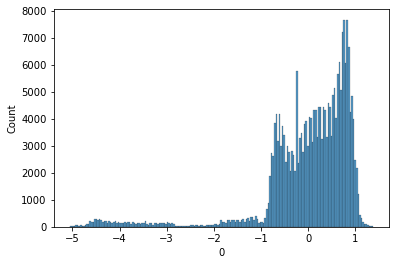

In [40]:
sns.histplot(test[0])

In [45]:
X_train_corr = X_train.copy()
X_train_corr['Is Goal'] = y_train
X_train_corr.columns

Index(['Game ID', 'Event Index', 'Period', 'Team', 'Shot Type', 'Shooter',
       'Shooter ID', 'Goalie', 'Goalie ID', 'Strength', 'X', 'Y',
       'Last event type', 'Last event X', 'Last event Y',
       'Last event elapsed time', 'Last event distance', 'st_X', 'st_Y',
       'Last event st_X', 'Last event st_Y', 'Shot distance', 'Shot angle',
       'Is Empty', 'Period seconds', 'Game seconds', 'Last event angle',
       'Rebound', 'Change in Shot Angle', 'Speed From Previous Event',
       'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season',
       'Num players With', 'Num players Against',
       'Elapsed time since Power Play', 'Is Goal'],
      dtype='object')

In [50]:
X_train_corr.drop(['Event Index', 'Shooter ID', 'Goalie ID', 'X', 'Y', 'Last event X', 'Last event Y'], axis=1, inplace=True)

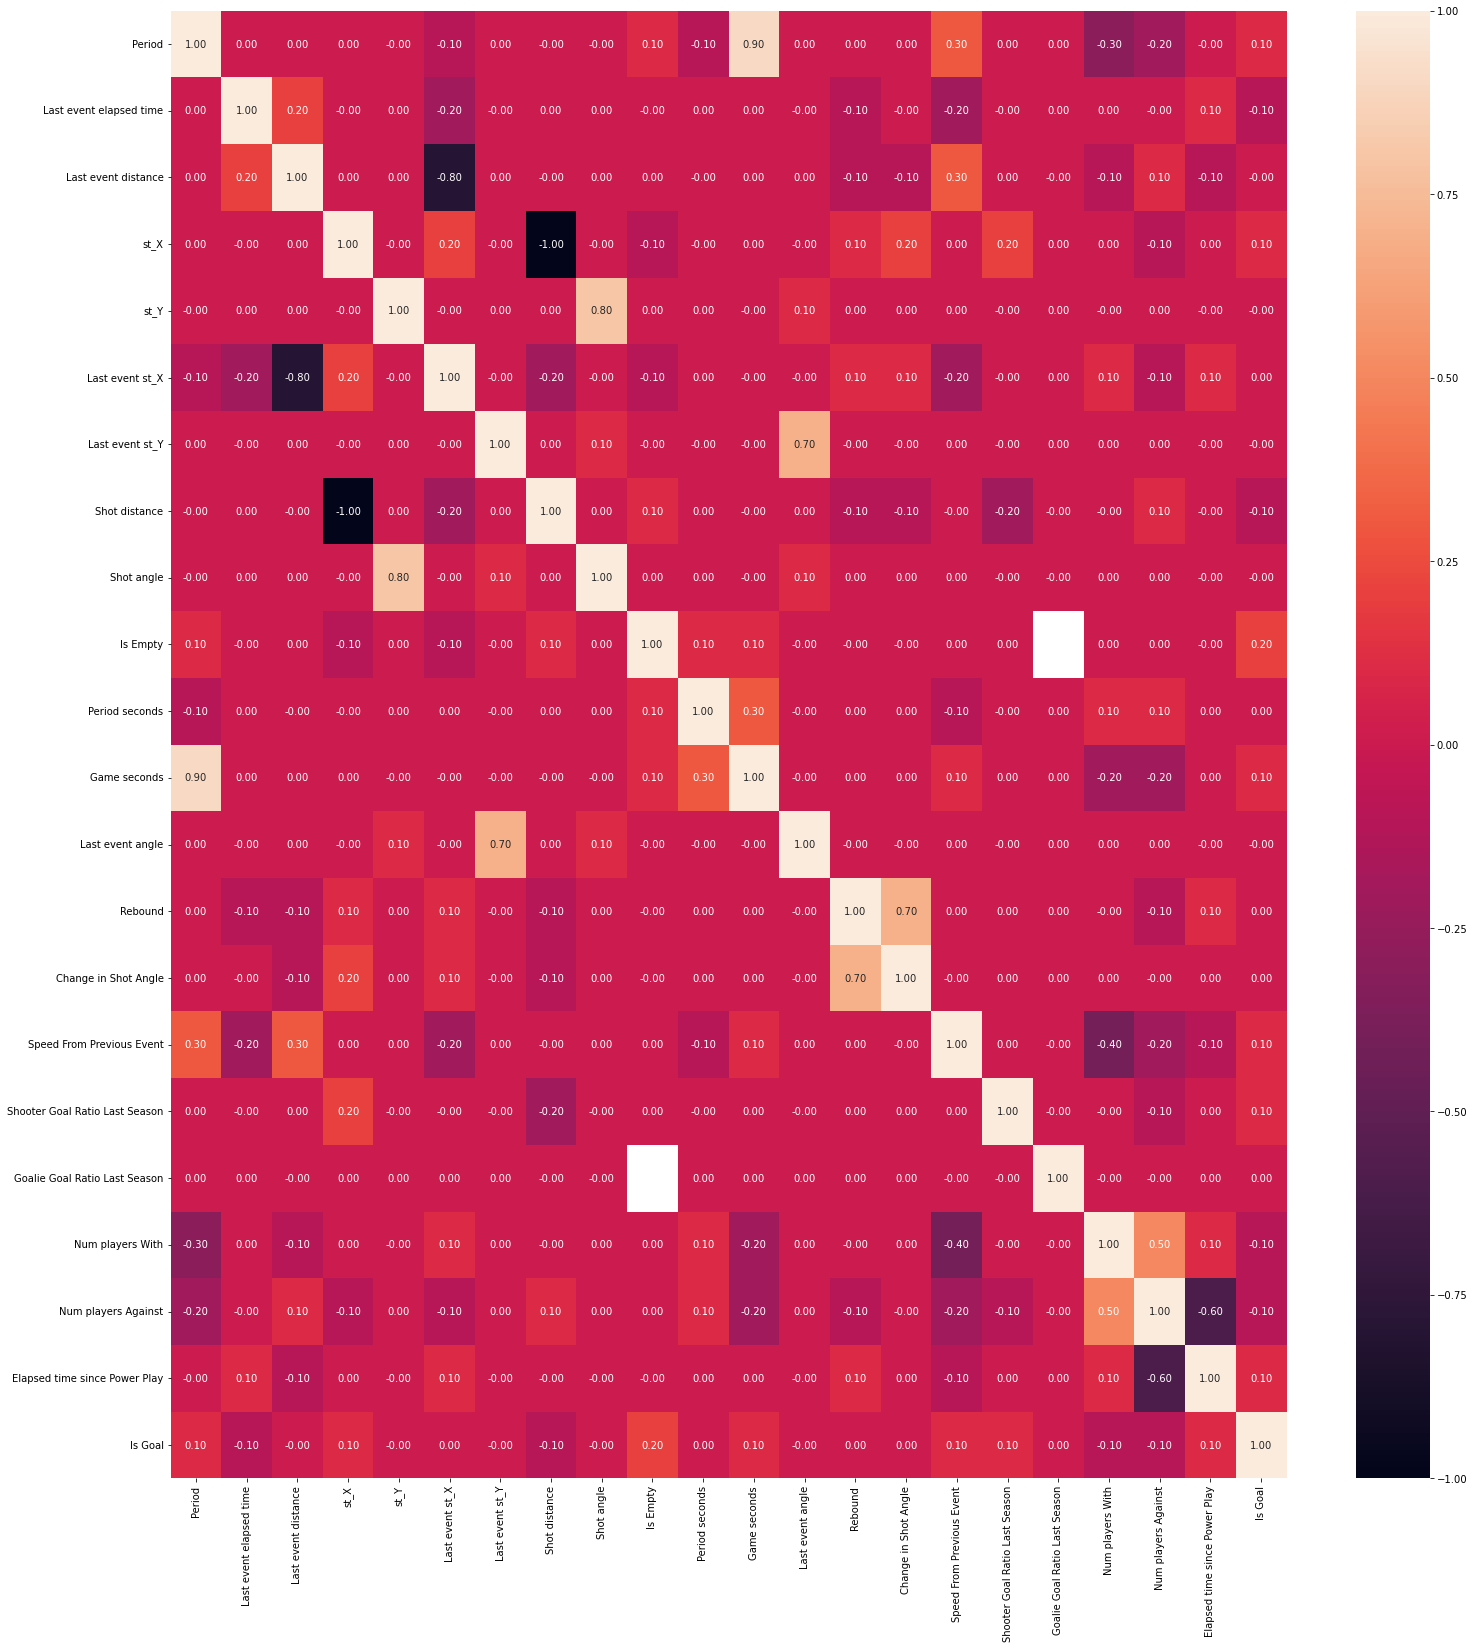

In [61]:
Smatrice_corr = X_train_corr.corr()
plt.figure(figsize=(25, 27))
sns.heatmap(data=matrice_corr, annot=True, fmt=".2f")
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma='auto').fit_predict(X_train[['st_X']]) # So slow, i killed the kernel, not sure how to interpret the result

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor().fit_predict(X_train[['st_X']])